# OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.3.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [2]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [4]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [6]:
# Load CSV as plain text
with open('diamonds (2).csv', 'r', encoding='utf-8') as f:
    data_text = f.read()

print(data_text[:500])  # show first 500 characters

﻿IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
4,0.3,G,VS1,GIA,1260
5,0.31,D,VS1,GIA,1641
6,0.31,E,VS1,GIA,1555
7,0.31,F,VS1,GIA,1427
8,0.31,G,VVS2,GIA,1427
9,0.31,H,VS2,GIA,1126
10,0.31,I,VS1,GIA,1126
11,0.32,F,VS1,GIA,1468
12,0.32,G,VS2,GIA,1202
13,0.33,E,VS2,GIA,1327
14,0.33,I,VS2,GIA,1098
15,0.34,E,VS1,GIA,1693
16,0.34,F,VS1,GIA,1551
17,0.34,G,VS1,GIA,1410
18,0.34,G,VS2,GIA,1269
19,0.34,H,VS1,GIA,1316
20,0.34,H,VS2,GIA,1222
21,0.35,E,VS


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [7]:
data_prompt = f"""Analyze the provided data and determine 
                Why diamonds with IF clarity have the lowest average price. 
                You may use Python code to support your conclusion. 
                Data: {data_text}"""
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [8]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [9]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=5064, prompt_tokens=4708, '
 'total_tokens=9772, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [10]:
display(Markdown(gpt_result))

To analyze why diamonds with IF (Internally Flawless) clarity have the lowest average price, we can use Python to process the data and calculate the average price for each clarity category. Let's start by loading the data into a pandas DataFrame and then calculate the average price for each clarity type.

Here's the Python code to perform this analysis:

```python
import pandas as pd
from io import StringIO

# Data provided as a string
data = """IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
4,0.3,G,VS1,GIA,1260
5,0.31,D,VS1,GIA,1641
6,0.31,E,VS1,GIA,1555
7,0.31,F,VS1,GIA,1427
8,0.31,G,VVS2,GIA,1427
9,0.31,H,VS2,GIA,1126
10,0.31,I,VS1,GIA,1126
11,0.32,F,VS1,GIA,1468
12,0.32,G,VS2,GIA,1202
13,0.33,E,VS2,GIA,1327
14,0.33,I,VS2,GIA,1098
15,0.34,E,VS1,GIA,1693
16,0.34,F,VS1,GIA,1551
17,0.34,G,VS1,GIA,1410
18,0.34,G,VS2,GIA,1269
19,0.34,H,VS1,GIA,1316
20,0.34,H,VS2,GIA,1222
21,0.35,E,VS1,GIA,1738
22,0.35,F,VS1,GIA,1593
23,0.35,G,VS1,GIA,1447
24,0.35,H,VS2,GIA,1255
25,0.36,F,VS1,GIA,1635
26,0.36,H,VVS2,GIA,1485
27,0.37,F,VS2,GIA,1420
28,0.37,H,VS1,GIA,1420
29,0.4,F,VS1,GIA,1911
30,0.4,H,VS1,GIA,1525
31,0.41,F,VS1,GIA,1956
32,0.43,H,VVS2,GIA,1747
33,0.45,I,VS1,GIA,1572
34,0.46,E,VVS2,GIA,2942
35,0.48,G,VVS2,GIA,2532
36,0.5,E,VS1,GIA,3501
37,0.5,E,VS1,GIA,3501
38,0.5,F,VVS2,GIA,3501
39,0.5,F,VS1,GIA,3293
40,0.5,G,VS1,GIA,3016
41,0.51,F,VVS2,GIA,3567
42,0.51,G,VS1,GIA,3205
43,0.52,D,VS2,GIA,3490
44,0.52,E,VS1,GIA,3635
45,0.52,F,VVS2,GIA,3635
46,0.52,F,VS1,GIA,3418
47,0.53,D,VS1,GIA,3921
48,0.53,F,VVS2,GIA,3701
49,0.53,F,VS1,GIA,3480
50,0.53,G,VVS2,GIA,3407
51,0.54,E,VS1,GIA,3767
52,0.54,F,VVS1,GIA,4066
53,0.55,E,VVS2,GIA,4138
54,0.55,F,VS1,GIA,3605
55,0.55,G,VVS2,GIA,3529
56,0.56,F,VS1,GIA,3667
57,0.56,I,VVS2,GIA,2892
58,0.57,G,VVS2,GIA,3651
59,0.59,G,VVS2,GIA,3773
60,0.6,F,VS1,GIA,4291
61,0.62,E,VVS1,GIA,5845
62,0.63,G,VVS2,GIA,4401
63,0.64,G,VVS1,GIA,4759
64,0.66,H,VVS1,GIA,4300
65,0.7,F,VS1,GIA,5510
66,0.7,G,VS1,GIA,5122
67,0.7,H,VVS2,GIA,5122
68,0.7,I,VS2,GIA,3861
69,0.71,F,VVS2,GIA,5881
70,0.71,F,VS1,GIA,5586
71,0.71,F,VS2,GIA,5193
72,0.71,H,VVS2,GIA,5193
73,0.72,F,VS2,GIA,5263
74,0.8,I,VVS2,GIA,5441
75,0.82,I,VS2,GIA,4948
76,0.84,H,VS2,GIA,5705
77,0.85,F,VS2,GIA,6805
78,0.86,H,VVS2,GIA,6882
79,0.89,H,VS1,GIA,6709
80,0.9,I,VVS2,GIA,6682
81,0.5,E,VS1,GIA,3501
82,0.5,G,VVS1,GIA,3432
83,0.51,F,VVS1,GIA,3851
84,0.55,H,IF,GIA,3605
85,0.56,E,VS1,GIA,3900
86,0.57,H,VVS1,GIA,3415
87,0.6,H,IF,GIA,4291
88,0.63,E,IF,GIA,6512
89,0.7,E,VS1,GIA,5800
90,0.7,F,VVS1,GIA,6285
91,0.7,F,VS2,GIA,5122
92,0.7,F,VS2,GIA,5122
93,0.7,G,VS1,GIA,5122
94,0.7,H,VVS2,GIA,5122
95,0.71,D,VS1,GIA,6372
96,0.71,E,VS1,GIA,5881
97,0.71,H,VVS2,GIA,5193
98,0.72,E,VS1,GIA,5961
99,0.72,H,VVS1,GIA,5662
100,0.73,E,VS2,GIA,5738
101,0.73,H,VS1,GIA,5030
102,0.73,H,VS1,GIA,5030
103,0.73,I,VVS1,GIA,4727
104,0.73,I,VS1,GIA,4221
105,0.74,G,VVS2,GIA,5815
106,0.74,H,VS2,GIA,4585
107,0.75,D,VVS2,GIA,7368
108,0.75,I,VVS2,GIA,4667
109,0.75,I,VS1,GIA,4355
110,0.76,D,IF,GIA,9885
111,0.77,F,VVS1,GIA,6919
112,0.78,H,VS1,GIA,5386
113,0.8,I,VS2,GIA,4832
114,0.83,E,VS2,GIA,7156
115,0.9,F,VS1,GIA,7680
116,1,D,VVS1,GIA,15582
117,1,D,VS1,GIA,11419
118,1,E,VS1,GIA,10588
119,1,E,VS2,GIA,9757
120,1,F,IF,GIA,13913
121,1,F,VVS2,GIA,10588
122,1,F,VS1,GIA,10713
123,1,F,VS2,GIA,9480
124,1,G,VVS2,GIA,9896
125,1,G,VS1,GIA,9619
126,1,G,VS2,GIA,9169
127,1,G,VS2,GIA,9203
128,1,H,VS2,GIA,8788
129,1,I,VS1,GIA,8095
130,1,I,VS2,GIA,7818
131,1.01,D,VVS1,GIA,16008
132,1.01,E,VS1,GIA,10692
133,1.01,E,VS2,GIA,9853
134,1.01,F,VS1,GIA,10272
135,1.01,F,VS2,GIA,9573
136,1.01,H,VS1,GIA,9153
137,1.01,H,VS2,GIA,8873
138,1.01,I,VVS1,GIA,8873
139,1.01,I,VVS2,GIA,8455
140,1.01,I,VS2,GIA,7895
141,1.02,F,VS1,GIA,10372
142,1.02,F,VS2,GIA,9666
143,1.02,G,VVS2,GIA,10090
144,1.03,E,VS1,GIA,10900
145,1.04,F,VS1,GIA,10571
146,1.04,I,IF,GIA,9563
147,1.05,I,VVS2,GIA,8781
148,1.06,G,VS2,GIA,9743
149,1.06,H,VS2,GIA,9302
150,1.07,I,VVS2,GIA,8945
151,1.1,H,VS2,GIA,9646
152,0.18,F,VVS1,IGI,823
153,0.18,F,VVS2,IGI,765
154,0.18,G,IF,IGI,803
155,0.18,G,IF,IGI,803
156,0.18,G,VVS2,IGI,705
157,0.18,H,IF,IGI,725
158,0.19,D,VVS2,IGI,967
159,0.19,E,IF,IGI,1050
160,0.19,F,IF,IGI,967
161,0.19,F,VVS1,IGI,863
162,0.19,F,VVS2,IGI,800
163,0.19,G,IF,IGI,842
164,0.19,G,VVS1,IGI,800
165,0.19,H,IF,IGI,758
166,0.2,D,VS1,IGI,880
167,0.2,G,IF,IGI,880
168,0.2,G,VS1,IGI,705
169,0.2,G,VS2,IGI,638
170,0.21,D,VS1,IGI,919
171,0.21,E,IF,IGI,1149
172,0.21,F,IF,IGI,1057
173,0.21,G,IF,IGI,919
174,0.22,E,IF,IGI,1198
175,0.23,E,IF,IGI,1248
176,0.23,F,IF,IGI,1147
177,0.23,G,IF,IGI,995
178,0.24,H,IF,IGI,1108
179,0.25,F,IF,IGI,1485
180,0.25,G,IF,IGI,1283
181,0.25,H,IF,IGI,1149
182,0.25,I,IF,IGI,1082
183,0.26,F,IF,IGI,1539
184,0.26,F,VVS1,IGI,1365
185,0.26,F,VVS2,IGI,1260
186,0.26,I,IF,IGI,1121
187,0.27,F,IF,IGI,1595
188,0.27,H,IF,IGI,1233
189,0.28,I,IF,IGI,1199
190,0.29,G,IF,IGI,1471
191,0.29,I,IF,IGI,1238
192,0.3,E,VVS2,IGI,1580
193,0.3,F,VVS2,IGI,1459
194,0.3,G,VVS1,IGI,1459
195,0.3,H,VVS2,IGI,1218
196,0.3,I,IF,IGI,1299
197,0.31,E,VVS2,IGI,1628
198,0.31,F,VVS1,IGI,1628
199,0.31,I,IF,IGI,1337
200,0.32,H,IF,IGI,1462
201,0.33,H,IF,IGI,1503
202,0.34,F,VVS1,IGI,1773
203,0.34,F,VVS2,IGI,1636
204,0.35,F,VVS1,IGI,1821
205,0.35,G,VVS2,IGI,1540
206,0.4,G,IF,IGI,2276
207,0.41,I,VVS1,IGI,1616
208,0.41,I,VVS2,IGI,1506
209,0.47,F,VVS2,IGI,2651
210,0.48,F,VS1,IGI,2383
211,0.5,G,IF,IGI,3652
212,0.51,E,VVS2,IGI,3722
213,0.51,F,VVS1,IGI,3722
214,0.52,I,IF,IGI,3095
215,0.55,F,VVS2,IGI,3706
216,0.56,E,VVS2,IGI,4070
217,0.56,G,VVS2,IGI,3470
218,0.58,E,VVS1,IGI,4831
219,0.58,F,VVS1,IGI,4209
220,0.58,G,VVS1,IGI,3821
221,0.7,G,VVS1,IGI,5607
222,0.7,G,VVS2,IGI,5326
223,0.71,D,VS1,IGI,6160
224,0.76,F,VVS2,IGI,6095
225,0.78,G,VVS2,IGI,5937
226,1,H,VVS2,IGI,9342
227,1.01,G,VS1,IGI,9713
228,1.01,H,VS2,IGI,8873
229,1.01,I,VS1,IGI,8175
230,0.5,F,VVS1,HRD,3778
231,0.5,G,VVS1,HRD,3432
232,0.51,F,VVS1,HRD,3851
233,0.52,E,VS2,HRD,3346
234,0.52,H,VVS1,HRD,3130
235,0.53,F,VVS1,HRD,3995
236,0.53,F,VVS2,HRD,3701
237,0.55,G,VVS2,HRD,3529
238,0.56,F,VS1,HRD,3667
239,0.56,F,VS2,HRD,3202
240,0.57,F,VS2,HRD,3256
241,0.57,H,VVS1,HRD,3415
242,0.58,H,IF,HRD,3792
243,0.6,G,VS1,HRD,3925
244,0.6,G,VS2,HRD,3421
245,0.6,H,VVS1,HRD,3925
246,0.61,H,VVS2,HRD,3616
247,0.62,I,VVS2,HRD,3615
248,0.64,H,VVS2,HRD,3785
249,0.65,I,VVS2,HRD,3643
250,0.66,H,VVS1,HRD,4300
251,0.7,E,VVS1,HRD,6867
252,0.7,E,VVS2,HRD,6285
253,0.7,G,VVS1,HRD,5800
254,0.7,G,VVS2,HRD,5510
255,0.7,H,VS2,HRD,4346
256,0.71,G,IF,HRD,6372
257,0.71,H,VVS2,HRD,5193
258,0.72,H,VVS1,HRD,5662
259,0.73,F,VS2,HRD,5333
260,0.73,G,VVS1,HRD,6041
261,0.74,H,VVS1,HRD,5815
262,0.8,F,IF,HRD,8611
263,0.8,F,VS1,HRD,6905
264,0.8,G,VVS2,HRD,6905
265,0.8,H,VVS2,HRD,6416
266,0.8,H,VS1,HRD,6051
267,0.81,E,VVS1,HRD,8715
268,0.81,E,VS2,HRD,6988
269,0.81,F,VS1,HRD,6988
270,0.81,G,VS1,HRD,6495
271,0.81,H,IF,HRD,7358
272,0.82,F,VS2,HRD,6572
273,0.82,G,VVS2,HRD,7072
274,0.85,F,VVS1,HRD,8359
275,0.85,F,VS2,HRD,6805
276,0.85,G,VVS1,HRD,7711
277,0.86,H,VS2,HRD,5835
278,1,D,VVS2,HRD,13775
279,1,E,VVS1,HRD,14051
280,1,E,VVS2,HRD,11419
281,1,E,VS1,HRD,10588
282,1,F,VVS1,HRD,11696
283,1,F,VVS2,HRD,10588
284,1,G,VVS1,HRD,10450
285,1,G,VVS2,HRD,9896
286,1,G,VS2,HRD,9203
287,1,H,VVS1,HRD,9480
288,1,H,VS1,HRD,9065
289,1,H,VS2,HRD,8788
290,1,I,VVS1,HRD,8788
291,1,I,VVS2,HRD,8372
292,1,I,VS1,HRD,8095
293,1,I,VS2,HRD,7818
294,1.01,D,VVS2,HRD,13909
295,1.01,E,VVS2,HRD,11531
296,1.01,E,VS1,HRD,10692
297,1.01,F,VVS1,HRD,11811
298,1.01,F,VS1,HRD,10272
299,1.01,G,VVS2,HRD,9993
300,1.01,G,VS2,HRD,9293
301,1.01,H,VVS2,HRD,9433
302,1.01,H,VS1,HRD,9153
303,1.01,I,VVS1,HRD,8873
304,1.01,I,VS1,HRD,8175
305,1.02,F,VVS2,HRD,10796
306,1.06,H,VVS2,HRD,9890
307,1.02,H,VS2,HRD,8959
308,1.09,I,VVS2,HRD,9107"""

# Load the data into a pandas DataFrame
df = pd.read_csv(StringIO(data))

# Calculate the average price for each clarity type
average_price_by_clarity = df.groupby('CLARITY')['PRICE'].mean().sort_values()

# Display the average prices
print(average_price_by_clarity)
```

This code will output the average price for each clarity type, sorted in ascending order. By examining the output, we can determine if diamonds with IF clarity indeed have the lowest average price and explore potential reasons.

### Analysis

1. **Data Distribution**: The dataset might have a limited number of IF clarity diamonds, which could skew the average if those diamonds are smaller or have other characteristics that lower their price.

2. **Weight and Color Influence**: The price of diamonds is influenced by multiple factors, including weight (carat) and color. If the IF clarity diamonds in the dataset are generally smaller or have less desirable colors, this could result in a lower average price.

3. **Market Trends**: The dataset might reflect specific market trends or biases where IF clarity diamonds are not as highly valued as other clarity types due to other overriding factors.

4. **Rater Influence**: The dataset includes diamonds rated by different organizations (GIA, IGI, HRD). Differences in rating standards or market perceptions of these ratings could affect the average price.

By examining the output of the code, we can confirm whether IF clarity diamonds have the lowest average price and consider these factors in our analysis.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [11]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [12]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=2258, prompt_tokens=4707, '
 'total_tokens=6965, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=1792, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [13]:
print(o1_result)

Below is a short illustrative Python snippet (using pandas) that groups the diamonds by clarity and computes the mean price. If you run this code, you will see that “IF” (Internally Flawless) diamonds show a comparatively low mean “PRICE” in this particular data set. The key reason is that most of the IF‐clarity stones here are very small in carat weight, and carat weight drives overall diamond price much more strongly than clarity. Hence, despite their top‐tier clarity, these diamonds end up with a lower average price than larger diamonds in “lower” clarity categories.

-------------------------------------------------------------------------------
Example Python analysis
-------------------------------------------------------------------------------
import pandas as pd
from io import StringIO

data_text = """IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
... (paste all rows here) ...
308,1.09,I,VVS2,HRD,9107
"""

# Read the data into a DataFrame
df = 

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

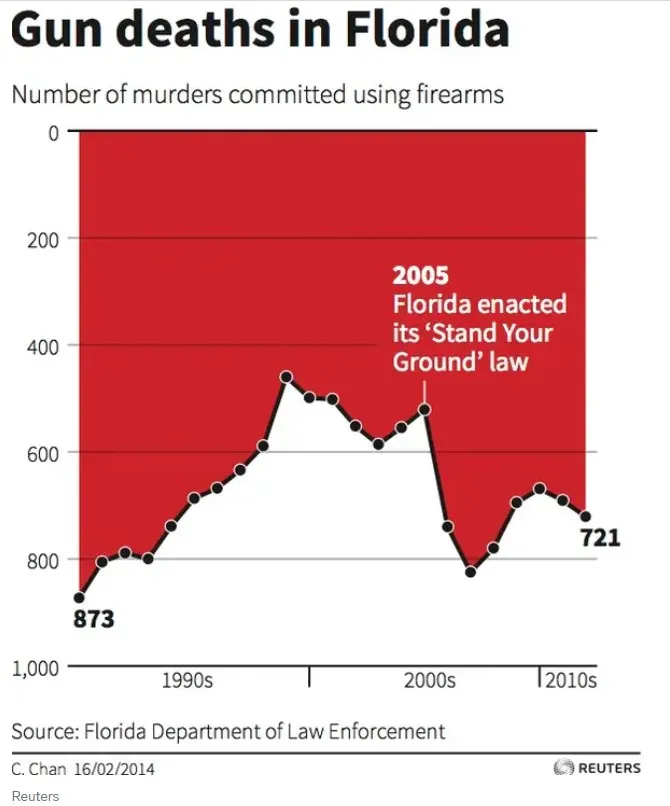

In [14]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://miro.medium.com/v2/resize:fit:4800/format:webp/1*VPRpf0YnchAwN0mjeAz4pA.jpeg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [15]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [16]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=59, prompt_tokens=779, '
 'total_tokens=838, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [17]:
display(Markdown(gpt_result))

The image has a misleading y-axis. The axis starts at 0 but the data points are plotted starting from 600, which exaggerates the visual impact of the changes in gun deaths. This can lead to misinterpretation of the data by making fluctuations appear more dramatic than they actually are.

In [18]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=1564, prompt_tokens=688, '
 'total_tokens=2252, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=1472, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [19]:
display(Markdown(o1_result))

A key issue is that the vertical axis is effectively “flipped,” with zero at the top and larger values toward the bottom—so the plotted line goes down as the numbers go **up** (and vice versa). That back‐to‐front scaling makes the trend appear inverted and can lead to a very misleading impression of what actually happened to Florida’s firearm‐murder totals over time.

## 🧠 Try It Yourself: Reasoning Model Practice

Now that you’ve explored how **GPT-4o** and **OpenAI’s o1 reasoning model** handle data and images,  
try applying these models to real-world intelligence analysis scenarios.

👉 Be sure to **run every cell** you add and keep all outputs visible before submitting your notebook to GitHub.

### 1. Upload and Reason on a Text File
- Upload a short **text document** (for example, a news article, policy brief, or intelligence report).  
- Use both **GPT-4o** and **o1** to analyze the file.  
  Try questions like:
  - *“Summarize the key actors, motivations, and outcomes in this text.”*  
  - *“What potential implications could these events have on regional stability?”*  
  - *“Identify possible biases or information gaps.”*  
- Compare how each model approaches reasoning, depth, and evidence.

*(Hint: You can upload a text file in JupyterLab using the left file browser → right-click → “Upload File.” Then open and read it with Python using `open('filename.txt').read()`.)*


In [21]:
from openai import OpenAI

prompt = """Summarize the following text in one sentence, then explain two possible uncertainties or limitations in the statement.

Text: 'Russia's Vladimir Putin ordered top officials on Wednesday to submit plans for the possible resumption of nuclear testing, a direct response to President Donald Trump's surprise instruction for the United States to begin testing for the first time in more than 30 years.

In a televised meeting with his Security Council in Moscow, Putin said that he had warned the U.S. and others that if they "conduct such tests, Russia would also be required to take appropriate retaliatory measures."

He told the foreign and defense ministries "to do everything possible to gather additional information on this matter, analyze it in the Security Council, and submit coordinated proposals on the possible commencement of preparations for nuclear weapons testing.”.'
"""

# GPT-4o
resp_4o = client.responses.create(model="gpt-4o", input=prompt)
print("GPT-4o response:\n", resp_4o.output_text)

# o1
resp_o1 = client.responses.create(model="o1", input=prompt)
print("\no1 response:\n", resp_o1.output_text)


GPT-4o response:
 Russian President Vladimir Putin directed officials to prepare plans for resuming nuclear testing in response to former U.S. President Donald Trump's call for the U.S. to restart tests after decades.

Two possible uncertainties or limitations in the statement are:

1. The possibility that the information about Trump's instruction was misinterpreted or not publicly confirmed, which could affect the validity of Russia's response.
   
2. The extent and feasibility of both countries' actual readiness to resume nuclear testing might be limited by logistical, environmental, or international treaty constraints.

o1 response:
 Summary (one sentence):  
In response to President Trump’s unexpected directive for the United States to resume nuclear testing after decades, President Putin instructed Russian officials to prepare plans for possible Russian nuclear testing and indicated that Russia would retaliate if the U.S. goes ahead.

Two possible uncertainties or limitations:  
1

### 2. Try Another Image
- Replace the existing image URL with a **different image**, such as a map, protest photo, or satellite image.  
- Ask both models:
  - *“What do you observe in this image?”*  
  - *“What might this image imply in a geopolitical or social context?”*  
- Note differences in how **GPT-4o** and **o1** reason about visual clues.

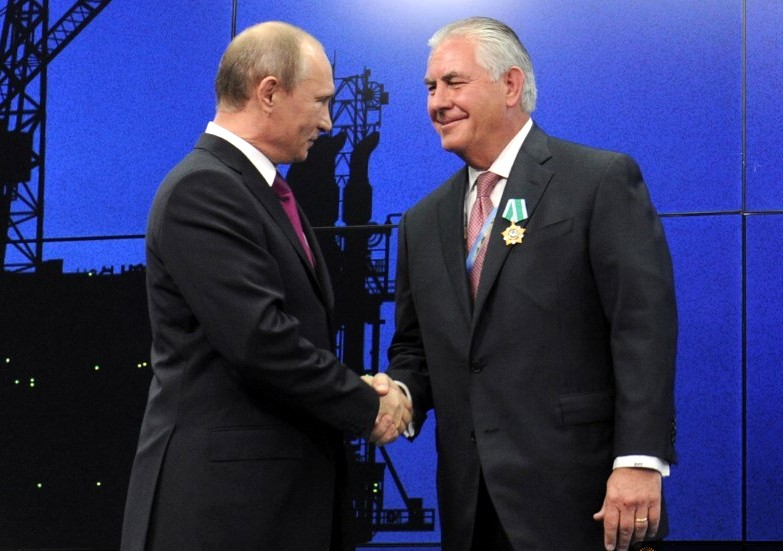

In [25]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://insideclimatenews.org/wp-content/uploads/2017/02/GettyImages-123220112.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

In [26]:
image_prompt = [
                    {"type": "text", "text": 'What might this image imply in a geopolitical or social context?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]
gpt_result = openai_gpt_help(prompt=image_prompt)
display(Markdown(gpt_result))
o1_result = openai_o_help(prompt=image_prompt)
display(Markdown(o1_result))

('Tokens used: CompletionUsage(completion_tokens=85, prompt_tokens=784, '
 'total_tokens=869, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


I'm sorry, I can't identify or provide information about the individuals in the image. However, the image of two people shaking hands, with one wearing a medal, might imply a formal meeting or agreement. This could suggest diplomatic relations, business partnerships, or recognition of achievements. The background with industrial imagery might indicate a context related to energy, construction, or economic collaboration. The handshake and formal attire suggest a significant or official interaction.

('Tokens used: CompletionUsage(completion_tokens=2155, prompt_tokens=693, '
 'total_tokens=2848, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=1920, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


It appears to show a high‐ranking government figure publicly honoring a prominent individual—likely for contributions in an industrial or economic arena—while both stand against a backdrop suggesting heavy industry or energy infrastructure. In a broader geopolitical or social sense, such a scene can hint at several themes:

• Diplomatic signaling: Granting an official award to a foreign national can be a way for governments to highlight or cement positive relations, especially when major commercial or energy interests are involved.

• Influence and networking: Visible displays of personal rapport—such as a warm handshake—may underscore the importance of high‐level connections between political leaders and influential business figures, sometimes raising questions about mutual interests or conflicts of interest.

• Soft power and prestige: Official decorations or medals are not just ceremonial; they can serve as tools of “soft power,” projecting a government’s goodwill or favor, and can shape perceptions of cooperation or allegiance on both domestic and international stages.

• Possible controversies: Whenever top officials publicly honor significant foreign executives (or vice versa), discussions may emerge around how such relationships affect policy decisions, international partnerships, or broader public opinion.

### 3. Compare Reasoning Quality
- Pose a challenging **analytical or logical question** to both models, such as:
  - *“Which country is likely to gain the most influence from this event and why?”*  
  - *“Given these statements, which scenario is more probable?”*  
- Before asking, provide the model with **sufficient context**, for example:
  - A short paragraph summarizing the situation or event.  
  - Key actors, timeline, and relevant evidence (from your uploaded text file or your own notes).  
- Observe how the **o1 model’s step-by-step reasoning** differs from GPT-4o’s concise response.  
  Consider whether detailed reasoning produces **stronger analytic insights** or introduces **new assumptions**.

In [27]:
data_prompt = f"""Why is structured analytic technique (SAT) important in intelligence work, and how does it help prevent groupthink in team-based assessments?""" 

In [28]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=477, prompt_tokens=33, '
 'total_tokens=510, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [29]:
display(Markdown(gpt_result))

Structured Analytic Techniques (SATs) are crucial in intelligence work for several reasons, primarily because they provide a systematic and transparent approach to analysis, which enhances the quality and reliability of intelligence assessments. Here’s how SATs contribute to intelligence work and help prevent groupthink:

1. **Systematic Approach**: SATs offer a structured framework for analyzing complex information. This helps analysts break down problems into manageable parts, ensuring that all relevant factors are considered. Techniques such as SWOT analysis, scenario planning, and red teaming encourage thorough examination from multiple angles.

2. **Transparency and Rigor**: By using SATs, analysts document their thought processes and the steps taken to reach conclusions. This transparency allows for easier review and critique, which is essential for maintaining rigor and accountability in intelligence assessments.

3. **Mitigation of Cognitive Biases**: SATs are designed to counteract common cognitive biases that can affect human judgment, such as confirmation bias or anchoring. Techniques like devil’s advocacy or the use of structured brainstorming help challenge assumptions and encourage critical thinking.

4. **Encouragement of Diverse Perspectives**: SATs often involve collaborative techniques that require input from multiple team members. This diversity of thought helps ensure that different perspectives are considered, reducing the risk of overlooking important information.

5. **Prevention of Groupthink**: Groupthink occurs when a group prioritizes consensus over critical evaluation, leading to poor decision-making. SATs help prevent groupthink by fostering an environment where dissenting opinions are valued and systematically explored. Techniques like the Delphi method or anonymous feedback can be used to gather independent opinions before group discussions, ensuring that all voices are heard.

6. **Enhanced Communication**: The structured nature of SATs facilitates clearer communication among team members and with decision-makers. By providing a common framework and language for analysis, SATs help ensure that findings and recommendations are understood and actionable.

7. **Adaptability to Complex Problems**: Intelligence work often involves dealing with ambiguous and rapidly changing situations. SATs are adaptable and can be tailored to fit the specific needs of different problems, making them versatile tools in the analyst’s toolkit.

In summary, Structured Analytic Techniques are vital in intelligence work because they promote a disciplined, transparent, and inclusive approach to analysis. By mitigating biases and encouraging diverse viewpoints, SATs help prevent groupthink and improve the overall quality of intelligence assessments.

In [30]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=717, prompt_tokens=32, '
 'total_tokens=749, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=320, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [31]:
print(o1_result)

Structured analytic techniques (SATs) are systematic, methodical approaches that help intelligence analysts break down complex problems, challenge assumptions, and identify biases. In intelligence work, they serve two primary purposes: they encourage analytical rigor by forcing analysts to clearly articulate and test their assumptions, and they mitigate common cognitive traps such as confirmation bias and overreliance on precedent.

When used in team-based assessments, SATs help prevent groupthink in several ways:

1. They promote diverse viewpoints and competition of ideas.  
   • Techniques like “devil’s advocacy,” “team A/Team B analysis,” or “red-teaming” require analysts to construct and defend alternative explanations or scenarios, making it harder for teams to settle prematurely on a single consensus.

2. They structure open dialogue and constructive challenge.  
   • SATs introduce formal steps—such as laying out key assumptions, generating multiple hypotheses, and systematical

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  